# Описание задачи

У меня есть хобби: плетение фенечек, то есть браслетов из ниток. Существует два вида плетения - прямое, когда нити основы фиксированы и плетение ведется не ими, и косое, когда плетение ведётся нитями основы. Визуально схемы прямого и косого плетения сильно отличаются друг от друга.

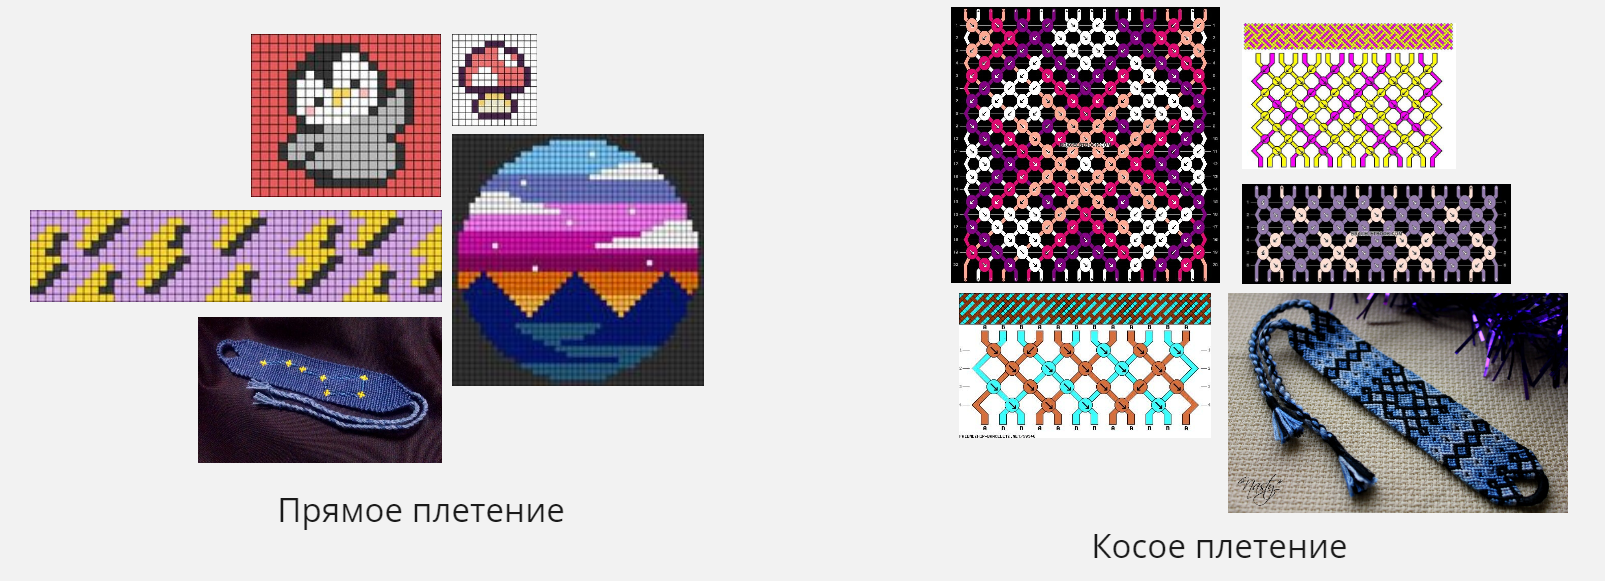

Часто происходит ситуация, когда ты находишь в интернете интересную схему и сохраняешь её в галерею телефона/компьютера, а потом теряешь среди других фотографий. Крайне неудобно вручную выискивать среди ~5000 фотографий все сохранённые схемы.

Этим продиктована необходимость алгоритма, способного выделять среди массива картинок схемы фенечек, а также разделять схемы по типу плетения на прямое и косое.

В перспективе предполагается, что на основе данного алгоритма можно будет разработать мобильное приложение, осуществляющее взаимодействие с галереей телефона.

# Общие импорты и настройки

In [1]:
%%capture
!pip install nest_asyncio aiohttp

In [2]:
import aiohttp
import asyncio
import nest_asyncio
nest_asyncio.apply()

import os
import shutil

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

from bs4 import BeautifulSoup
import requests
import re

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from skimage.io import imsave, imshow, imread
import cv2

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = "/content/drive/MyDrive/Fenechky/Data"

# Сбор данных

В качестве первого источника данных, представляющих собой схемы фенечек, используется сайт https://www.braceletbook.com/patterns/. Он удобен тем, что все схемы лежат в одном месте, и существует возможность применить фильтр, разделяющий прямое (Alpha) и косое (Normal) плетение.

В качестве второго источника используется сайт https://fenkoplet.ru/schemes/. Схемы на этом сайте концептуально ничем не отличаются от представленных на первом, но имеют немного другой формат. Например, для косого плетения схема и превью объединены на одной картинке.


In [5]:
# Класс, реализующий логику по получению всех ссылок на схемы фенечек из 
# вышеуказанных источников и сохраняющий картинки по данным сслыкам в указанную папку

class WebScraper(): 
    def __init__(self, pattern_type="Alpha", pages_limit=None, max_urls_alpha=900, 
                 max_urls_normal=810):  # информация про макс. кол-во взята с сайта
        self.pattern_type = pattern_type
        self.urls = self.get_urls("a", max_urls_alpha) if pattern_type == "Alpha" \
                                            else self.get_urls("n", max_urls_normal)  
        if pages_limit is not None:
            self.urls = self.urls[:pages_limit]
        self.all_data = []
    
    def run(self):
        asyncio.run(self.main())
        self.all_data = self.flatten(self.all_data)

    def save(self, path):
        for i, url in enumerate(self.all_data):
            try:
                img = imread(url)
                imsave(f"{path}/{self.pattern_type}/{self.pattern_type}_{i}.jpg", 
                       img[:, :, 0:3])
            except Exception as e:
                print(str(e))

    def flatten(self, list_of_lists):
        if not len(list_of_lists):
            return list_of_lists
        if isinstance(list_of_lists[0], list):
            return self.flatten(list_of_lists[0]) + self.flatten(list_of_lists[1:])
        return list_of_lists[:1] + self.flatten(list_of_lists[1:])

    def get_urls(self, type, max_pages):
        first_url = [
            f"https://www.braceletbook.com/patterns/?type={type}&order-by=photos&has-photos=1"
            ]
        other_urls = [
            f"https://www.braceletbook.com/patterns/page-{page_number}/?type={type}&order-by=photos&has-photos=1"
            for page_number in range(2, max_pages+1)
            ]
        return first_url + other_urls
            
    async def extract_pictures_links(self, page):
        try:
            soup = BeautifulSoup(page, 'html.parser')
            pictures_with_garbage = soup.findAll("img", {"alt": 
                                                        re.compile(f"{self.pattern_type} pattern .*{'pattern' if self.pattern_type == 'Normal' else ''}")})
            pictures_links = list(map(lambda text: 
                                      text.get("src"), pictures_with_garbage))
            return pictures_links
        except Exception as e:
            print(str(e))

    async def fetch_pictures_links(self, session, url):
        try:
            async with session.get(url) as response:
                page = await response.text()
                pictures_links = await self.extract_pictures_links(page)
                return pictures_links
        except Exception as e:
            print(str(e))

    async def fetch_normal_pictures_links(self, session, url):
        try:
            async with session.get(url) as response:
                page = await response.text()
                soup = BeautifulSoup(page, 'html.parser')
                links_to_pages_with_garbage = soup.findAll("a", 
                                                           {"class": "img"})
                normal_urls = list(map(lambda text: text.get("href"), 
                                       links_to_pages_with_garbage))
                tasks = []
                for normal_url in normal_urls:
                    tasks.append(self.fetch_pictures_links(session, normal_url))
                pictures_links = await asyncio.gather(*tasks)
                return pictures_links
        except Exception as e:
            print(str(e))

    async def get_extra_data(self, session, url):
        try:
            async with session.get(url) as response:
                page = await response.text()
                pictures_links = await self.extract_extra_pictures_links(page)
                return pictures_links
        except Exception as e:
            print(str(e))

    async def extract_extra_pictures_links(self, page):
        try:
            soup = BeautifulSoup(page, "html.parser")
            pictures_soup = soup.findAll("a", {"class": "ngg-fancybox"})
            pictures_links = list(map(lambda text: text.get("data-src"), pictures_soup))
            return pictures_links
        except Exception as e:
            print(str(e))

    async def main(self):
        tasks = []
        async with aiohttp.ClientSession() as session:
            if self.pattern_type == "Alpha":
                for url in self.urls:
                    tasks.append(self.fetch_pictures_links(session, url))
                for url in [f"https://fenkoplet.ru/schemes/alpha/{part}" for part in 
                            ["alphabets/", "girls_names/", "boys_names/", "signs/", "logo/", "cartoons/", "hearts/",
                            "music/", "animals/", "cats/", "dogs/", "marine/", "owl_schemes/", "eastern/",
                            "flags/", "smiles/", "ornament/", "halloween/", "christmas/", "owl_schemes/", "eastern/"]]:
                    tasks.append(self.get_extra_data(session, url))
            else:
                for url in self.urls:
                    tasks.append(self.fetch_normal_pictures_links(session, url))
                for url in [f"https://fenkoplet.ru/schemes/normal/{part}" for part in 
                            ["to10/", "10-to-20/", "20-to-30/", "30-to-40/", "40-to-50/", "50-to-60/", "60-to-70/"]]:
                    tasks.append(self.get_extra_data(session, url))
            pictures_links = await asyncio.gather(*tasks)
            self.all_data.extend(pictures_links)

Все исключения, возникающие в процессе работы кода, игнорируются, но выводятся в строковом формате. Идея заключается в том, что потерять с десяток картинок выгоднее, чем отдельно обработать каждое исключение.

In [ ]:
scraper_alpha = WebScraper(pattern_type="Alpha", pages_limit=100)
scraper_alpha.run()
scraper_alpha.save(PATH)

In [ ]:
scraper_normal = WebScraper(pattern_type="Normal", pages_limit=100)
scraper_normal.run()
scraper_normal.save(PATH)

В качестве данных, представляющих собой не-схемы, использована коллекция фотографий готовых фенечек из группы Фенькоплёт ВКонтакте (https://vk.com/fenkopletru), датасет с Kaggle (https://www.kaggle.com/datasets/n0obcoder/mobile-gallery-image-classification-data), а также личная коллекция фотографий.

# Разделение на train, val и test

Данные необходимо разделить на train, val и test выборки. В качестве данных возьмем 1000 случайных картинок из каждого класса. Соотношение train, val и test будет 70:20:10.

In [ ]:
train_dir = "train"
val_dir = "val"
test_dir = "test"
train_data_portion = 0.7
val_data_portion = 0.2
test_data_portion = 0.1
images_per_class = 1000

Создадим необходимые для хранения данных директории.

In [ ]:
for store in [train_dir, val_dir, test_dir]:
    for label in ["Alpha", "Normal", "Other"]:
        os.makedirs(f"{PATH}/{store}/{label}")

Найдем индексы для дальнейшего копирования изображений.

In [ ]:
begins_and_ends = {"train": [0, int(images_per_class * train_data_portion)], 
                   "val": [int(images_per_class * train_data_portion), 
                           int(int(images_per_class * train_data_portion) + images_per_class * val_data_portion)], 
                   "test": [int(int(images_per_class * train_data_portion) + images_per_class * val_data_portion), 
                            images_per_class]}

Скопируем изображения в нужной пропорции в директории train, val и test.

In [ ]:
for label in ["Alpha", "Normal", "Other"]:
    current_pictures = os.listdir(f"{PATH}/{label}")
    random.shuffle(current_pictures)  # перемешаем данные в случайном порядке 
    for store, begin_end in begins_and_ends.items():
        begin, end = begin_end
        for picture in current_pictures[begin:end]:
            shutil.copy2(f"{PATH}/{label}/{picture}", f"{PATH}/{store}/{label}")

Посмотрим всякие статистики по датасету.

In [ ]:
def get_dataset_stats(dataset_path=PATH):
    train_dir = dataset_path + '/train'
    val_dir = dataset_path + '/val'
    test_dir = dataset_path + '/test'

    len_classes = len(os.listdir(train_dir))

    assert (len(os.listdir(train_dir)) == len(os.listdir(val_dir)) and 
            len(os.listdir(val_dir)) == len(os.listdir(test_dir)))

    avg_height = 0
    min_height = np.inf
    max_height = 0

    avg_width = 0
    min_width = np.inf
    max_width = 0

    total_train = 0
    print('\nTraining dataset stats:')
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        class_images = os.listdir(class_path)
        
        for img_name in class_images:
            try:
                h, w, c = imread(os.path.join(class_path, img_name)).shape
            except ValueError:  # проверка на битые файлы
                os.remove(os.path.join(class_path, img_name))
                continue
            avg_height += h
            avg_width += w
            min_height = min(min_height, h)
            min_width = min(min_width, w)
            max_height = max(max_height, h)
            max_width = max(max_width, w)
        
        total_train += len(class_images)
        print(f'--> Images in {class_name}: {len(class_images)}')
    
    total_val = 0
    print('\nValidation dataset stats:')
    for class_name in os.listdir(val_dir):
        class_path = os.path.join(val_dir, class_name)
        class_images = os.listdir(class_path)
        
        for img_name in class_images:
            try:
                h, w, c = imread(os.path.join(class_path, img_name)).shape
            except ValueError: # проверка на битые файлы
                os.remove(os.path.join(class_path, img_name))
                continue
            avg_height += h
            avg_width += w
            min_height = min(min_height, h)
            min_width = min(min_width, w)
            max_height = max(max_height, h)
            max_width = max(max_width, w)

        total_val += len(class_images)
        print(f'--> Images in {class_name}: {len(os.listdir(os.path.join(val_dir, class_name)))}')

    total_test = 0
    print('\nTesting dataset stats:')
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        class_images = os.listdir(class_path)
        
        for img_name in class_images:
            try:
                h, w, c = imread(os.path.join(class_path, img_name)).shape
            except ValueError: # проверка на битые файлы
                os.remove(os.path.join(class_path, img_name))
                continue
            avg_height += h
            avg_width += w
            min_height = min(min_height, h)
            min_width = min(min_width, w)
            max_height = max(max_height, h)
            max_width = max(max_width, w)
        
        total_test += len(class_images)
        print(f'--> Images in {class_name}: {len(class_images)}')

    img_height = avg_height // (total_train + total_val + total_test)
    img_width = avg_width // (total_train + total_val + total_test)
    
    print()
    print(f'avg_img_height: {img_height}')
    print(f'avg_img_width: {img_width}')
    print(f'min_height: {min_height}')
    print(f'min_width: {min_width}')
    print(f'max_height: {max_height}')
    print(f'max_width: {max_width}')
    print()

In [ ]:
get_dataset_stats()


Training dataset stats:
--> Images in Other: 700
--> Images in Normal: 700
--> Images in Alpha: 700

Validation dataset stats:
--> Images in Other: 199
--> Images in Normal: 200
--> Images in Alpha: 200

Testing dataset stats:
--> Images in Other: 100
--> Images in Normal: 100
--> Images in Alpha: 100

avg_img_height: 1095
avg_img_width: 953
min_height: 12
min_width: 15
max_height: 7368
max_width: 4928



# Модель. Обучение и оценка

Referencing https://towardsdatascience.com/implementing-a-fully-convolutional-network-fcn-in-tensorflow-2-3c46fb61de3b;  https://www.geeksforgeeks.org/python-image-classification-using-keras/

In [6]:
# Нейронная сеть

def NN_model(input_shape, len_classes, dropout_rate=0.25):

    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    model.add(Conv2D(64, (2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len_classes))
    model.add(Activation('softmax'))
    
    print(model.summary())
    print(f'Total number of layers: {len(model.layers)}')

    return model

In [7]:
# Планировщик

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

In [8]:
# Класс для предобработки картинок и их динамической передачи в модель

class Generator(tf.keras.utils.Sequence):
    def __init__(self, dataset_path, batch_size=16, shuffle_images=True, target_image_size=(400, 400)):
        self.image_groups = None
        self.label_groups = None
        self.batch_size = batch_size
        self.shuffle_images = shuffle_images
        self.height = target_image_size[0]
        self.width = target_image_size[1]
        self.load_image_paths_labels(dataset_path)
        self.create_image_groups()
    
    def load_image_paths_labels(self, dataset_path):
        classes = os.listdir(dataset_path)
        lb = preprocessing.LabelBinarizer()
        lb.fit(classes)
        self.image_paths = []
        self.image_labels = []
        for class_name in classes:
            class_path = os.path.join(dataset_path, class_name)
            for image_file_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, image_file_name))
                self.image_labels.append(class_name)
        self.image_labels = np.array(lb.transform(self.image_labels), dtype='float32')
        assert len(self.image_paths) == len(self.image_labels)

    def create_image_groups(self):
        if self.shuffle_images:
            seed = 14
            np.random.seed(seed)
            np.random.shuffle(self.image_paths)
            np.random.seed(seed)
            np.random.shuffle(self.image_labels)
        
        self.image_groups = [[self.image_paths[x % len(self.image_paths)] for x in range(i, i + self.batch_size)]
                              for i in range(0, len(self.image_paths), self.batch_size)]
        self.label_groups = [[self.image_labels[x % len(self.image_labels)] for x in range(i, i + self.batch_size)]
                              for i in range(0, len(self.image_labels), self.batch_size)]

    def resize_image(self, image, inter=cv2.INTER_AREA):  # изменение размера картинки с сохранением aspect_ratio
      dim = None
      (h, w) = image.shape[:2]
      if self.width is None and self.height is None:
          return image
      if self.width is None:
          r = self.height / float(h)
          dim = (int(w * r), self.height)
      else:
          r = self.width / float(w)
          dim = (self.width, int(h * r))
      resized = cv2.resize(image, dim, interpolation=inter)
      new_img = resized[:self.height, :self.width, :]  # если картинка всё ещё слишком большая, она обрезается до нужного размера
      return new_img

    def load_images(self, image_group):
        images = []
        for image_path in image_group:
            img = cv2.imread(image_path)
            img_shape = len(img.shape)
            if img_shape == 2:
                img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            elif img_shape == 4:
                img = cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)
            elif img_shape == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = self.resize_image(img)
            img = img / 255  # нормализация
            images.append(img)
        return images

    def construct_image_batch(self, image_group):
        max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))
        image_batch = np.zeros((self.batch_size,) + max_shape, dtype='float32')
        for image_index, image in enumerate(image_group):
            image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image
        return image_batch
    
    def __len__(self):
        return len(self.image_groups)

    def __getitem__(self, index):
        image_group = self.image_groups[index]
        label_group = self.label_groups[index]
        images = self.load_images(image_group)
        image_batch = self.construct_image_batch(images)
        return image_batch, np.array(label_group)

In [9]:
# Функция для тренировки модели и вывода информации в процессе

def train(model, train_generator, val_generator, epochs=10):
    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    checkpoint_path = './snapshots'
    os.makedirs(checkpoint_path, exist_ok=True)
    model_path = os.path.join(checkpoint_path, 'model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}_val_acc_{val_accuracy:.2f}.h5')
    
    history = model.fit_generator(generator=train_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=epochs,
                        callbacks = [
                            tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
                            tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
                        ],
                        validation_data=val_generator,
                        validation_steps=len(val_generator))
    return history

In [10]:
# Инициализация всего

heigth, width, dims = 250, 250, 3

model = NN_model(input_shape=(heigth, width, dims), len_classes=3, dropout_rate=0.5)

train_dir = PATH + "/train"
val_dir = PATH + "/val"
test_dir = PATH + "/test"

batch_size = 16
train_generator = Generator(train_dir, batch_size, shuffle_images=True, target_image_size=(heigth, width))
val_generator = Generator(val_dir, batch_size, shuffle_images=True, target_image_size=(heigth, width))
test_generator = Generator(test_dir, batch_size, shuffle_images=True, target_image_size=(heigth, width))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 246, 246, 32)      2432      
                                                                 
 activation (Activation)     (None, 246, 246, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 47, 47, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                    

In [11]:
# Обучение модели

epochs = 15
history = train(model, train_generator, val_generator, epochs=epochs)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
132/132 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.7538
Epoch 1: val_loss improved from inf to 0.32394, saving model to ./snapshots/model_epoch_01_val_loss_0.32_val_acc_0.84.h5
132/132 [==============================] - 1115s 8s/step - loss: 0.5841 - accuracy: 0.7538 - val_loss: 0.3239 - val_accuracy: 0.8372 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
132/132 [==============================] - ETA: 0s - loss: 0.3431 - accuracy: 0.8532
Epoch 2: val_loss improved from 0.32394 to 0.30369, saving model to ./snapshots/model_epoch_02_val_loss_0.30_val_acc_0.91.h5
132/132 [==============================] - 133s 1s/step - loss: 0.3431 - accuracy: 0.8532 - val_loss: 0.3037 - val_accuracy: 0.9062 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/15
132/132 [===========

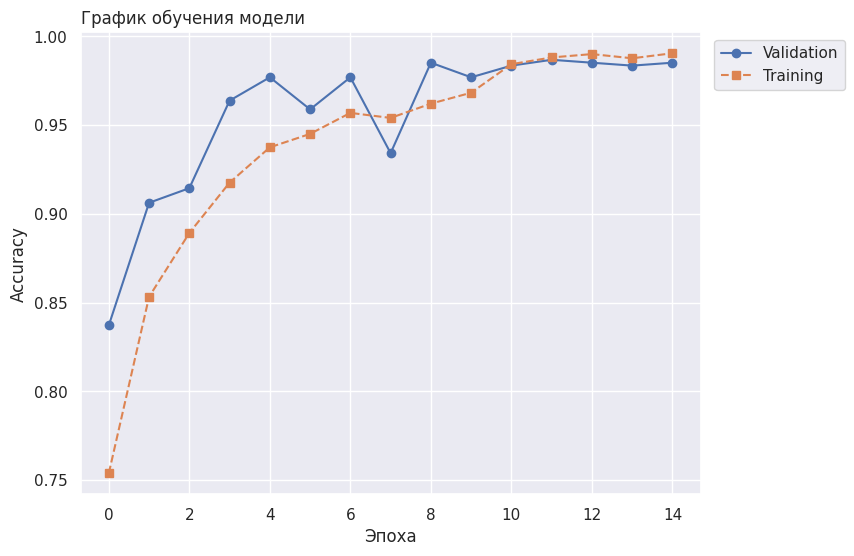

In [12]:
plt.figure(figsize=(8, 6))
plt.title("График обучения модели", loc='left')
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.plot(history.history['val_accuracy'], '-o', label='Validation')
plt.plot(history.history['accuracy'], '--s', label='Training')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

Видно, что начиная с 12 эпохи пошло переобучение.

In [13]:
# Загрузка модели
def load_model(input_h5_file):
    return tf.keras.models.load_model(input_h5_file)

# Экспорт модели
def export(input_h5_file, export_path):
    tf.keras.backend.set_learning_phase(0)  # Ignore dropout at inference
    model = load_model(input_h5_file)
    model.save(export_path)
    print(f"SavedModel created at {export_path}")

Возьмем наилучшую получившуюся модель.

In [15]:
model = load_model("./snapshots/model_epoch_09_val_loss_0.07_val_acc_0.99.h5")

Посмотрим качество модели на отложенных тестовых данных.

In [16]:
scores = model.evaluate_generator(test_generator, len(test_generator))
print("Аccuracy на тестовых данных: %.2f%%" % (scores[1]*100))

Аccuracy на тестовых данных: 96.71%


19/19 [==============================] - 17s 914ms/step
              precision    recall  f1-score   support

       Alpha       0.93      0.97      0.95       100
      Normal       0.99      0.99      0.99       100
       Other       0.98      0.94      0.96       100

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



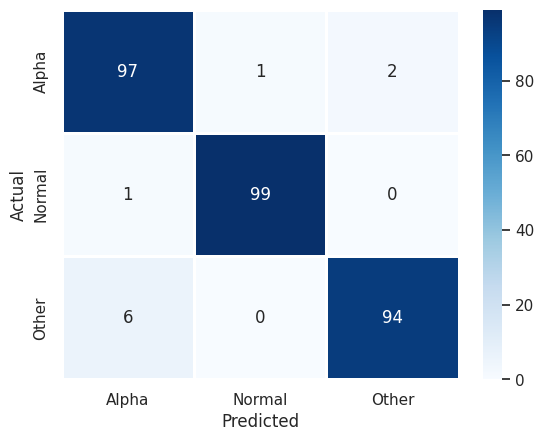

In [17]:
test_pred = model.predict(test_generator)[:len(test_generator.image_labels)]
test_pred_classes = test_pred.argmax(1)
test_true = test_generator.image_labels.argmax(1)

print(classification_report(test_true, test_pred_classes, 
                            labels=[0, 1, 2], target_names=['Alpha', 'Normal', 'Other']))

confusion_mtx = confusion_matrix(test_true, test_pred_classes) 
ax = sns.heatmap(confusion_mtx, annot=True, cmap="Blues", 
                 linewidths=1, fmt='g')
ax.set_xticklabels(['Alpha', 'Normal', 'Other'])
ax.set_yticklabels(['Alpha', 'Normal', 'Other'], rotation=90, va='center')
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()

Посмотрим, где модель ошибается.

In [18]:
classes = {0: 'Alpha', 1: 'Normal', 2: 'Other'}

ix = np.where(test_true != test_pred_classes)[0]
fig, axes = plt.subplots(nrows=len(ix), figsize=(8, 50))
for i, ax in enumerate(axes):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(imread(test_generator.image_paths[ix[i]]))
    ax.set_title(f"Истина: {classes[test_true[ix[i]]]}, предсказание: {classes[test_pred_classes[ix[i]]]}")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Сохраним модель.

In [21]:
input_h5_file = "./snapshots/model_epoch_09_val_loss_0.07_val_acc_0.99.h5"
export_path = "/content/drive/MyDrive/Fenechky/model_epoch_09_val_loss_0.07_val_acc_0.99.h5"
export(input_h5_file, export_path)

SavedModel created at /content/drive/MyDrive/Fenechky/model_epoch_09_val_loss_0.07_val_acc_0.99.h5


# Предсказание для нескольких картинок

In [22]:
# Класс для предобработки картинок и их динамической передачи в модель

class GeneratorForPrediction(tf.keras.utils.Sequence):
    def __init__(self, paths_to_images, batch_size=16, target_image_size=(400, 400)):
        self.batch_size = batch_size
        self.height = target_image_size[0]
        self.width = target_image_size[1]
        self.image_group = paths_to_images

    def resize_image(self, image, inter=cv2.INTER_AREA):  # изменение размера картинки с сохранением aspect_ratio
      dim = None
      (h, w) = image.shape[:2]
      if self.width is None and self.height is None:
          return image
      if self.width is None:
          r = self.height / float(h)
          dim = (int(w * r), self.height)
      else:
          r = self.width / float(w)
          dim = (self.width, int(h * r))
      resized = cv2.resize(image, dim, interpolation=inter)
      new_img = resized[:self.height, :self.width, :]  # если картинка всё ещё слишком большая, она обрезается до нужного размера
      return new_img

    def load_images(self, image_group):
        images = []
        for image_path in image_group:
            img = cv2.imread(image_path)
            img_shape = len(img.shape)
            if img_shape == 2:
                img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            elif img_shape == 4:
                img = cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)
            elif img_shape == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = self.resize_image(img)
            img = img / 255  # нормализация
            images.append(img)
        return images

    def construct_image_batch(self, image_group):
        max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))
        image_batch = np.zeros((self.batch_size,) + max_shape, dtype='float32')
        for image_index, image in enumerate(image_group):
            image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image
        return image_batch
    
    def __len__(self):
        return len(self.image_group)

    def __getitem__(self, index):
        images = self.load_images(self.image_group)
        image_batch = self.construct_image_batch(images)
        return image_batch

In [23]:
classes = {0: 'Alpha', 1: 'Normal', 2: 'Other'}

def decode_predictions(predictions):
    labels = [classes[np.argmax(preds)] for preds in predictions]
    return labels

def find_type(image_paths, model):
    generator = GeneratorForPrediction(image_paths, batch_size, target_image_size=(heigth, width))
    predictions = model.predict(generator)
    labels = decode_predictions(predictions)
    return labels

В функцию передаются пути к файлам-картинкам.

In [26]:
image_paths = [
                f"{PATH}/test/Alpha/Alpha_25.jpg", 
                f"{PATH}/test/Alpha/Alpha_300.jpg",
                f"{PATH}/test/Other/Other_589.jpg",
                f"{PATH}/test/Normal/Normal_3472.jpg",
                f"{PATH}/test/Normal/Normal_832.jpg",
               ]
predictions = find_type(image_paths, model)

5/5 [==============================] - 2s 380ms/step


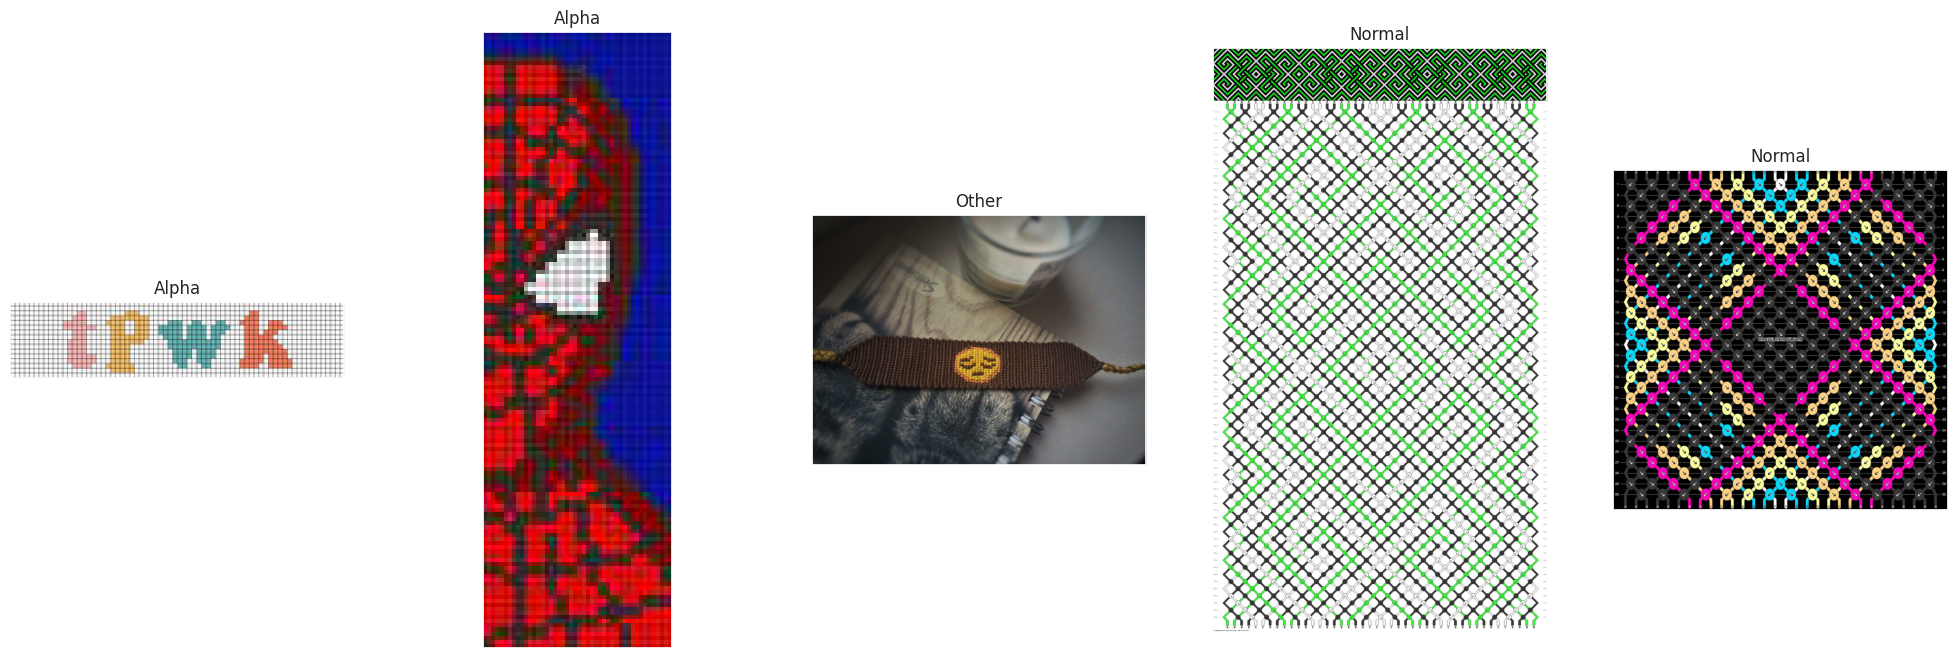

In [27]:
fig, axes = plt.subplots(ncols=len(image_paths), figsize=(25, 8))
for i, ax in enumerate(axes):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(imread(image_paths[i]))
    ax.set_title(predictions[i])
plt.show()

# Итог

На основе нейросетевого подхода был разработан мультиклассовый классификатор для разделения изображений на три класса: схемы фенечек прямого плетения, схемы фенечек косого плетения и остальные фотографии. 

Accuracy на отложенной выборке из 300 элементов составила 97%.